In [1]:
!pip install transformers datasets
!pip install evaluate
import torch
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.7 MB/s eta 0:00:00


In [2]:
!pip install conllu

In [3]:
import conllu

In [4]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def load_conllu(filename):
  for sentence in conllu.parse(open(filename, "rt", encoding="utf-8").read()):
    tokenized_words = [token["form"] for token in sentence]
    gold_tags = [token["upos"] for token in sentence]
    yield tokenized_words, gold_tags

corpus = list(load_conllu("/content/drive/MyDrive/fr_sequoia-ud-test.conllu"))

In [6]:
print(corpus[0])

(['cela', 'signifie', 'que', 'leur', 'consommation', 'énergétique', ',', 'qui', 'représente', 'actuellement', '10', '%', 'de', 'la', 'consommation', 'énergétique', 'moyenne', 'de', "l'", 'UE', ',', 'enregistrera', 'une', 'forte', 'augmentation', 'à', 'mesure', "qu'", 'ils', 'exigeront', 'des', 'commodités', 'élémentaires', 'comme', "l'", 'eau', 'chaude', 'et', ',', 'peut-être', 'même', ',', "l'", 'air', 'conditionné', ',', 'des', 'moyens', 'de', 'transport', 'et', 'la', 'modernisation', 'de', 'leurs', 'industries', '.'], ['PRON', 'VERB', 'SCONJ', 'DET', 'NOUN', 'ADJ', 'PUNCT', 'PRON', 'VERB', 'ADV', 'NUM', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADJ', 'ADJ', 'ADP', 'DET', 'PROPN', 'PUNCT', 'VERB', 'DET', 'ADJ', 'NOUN', 'ADP', 'NOUN', 'SCONJ', 'PRON', 'VERB', 'DET', 'NOUN', 'ADJ', 'ADP', 'DET', 'NOUN', 'ADJ', 'CCONJ', 'PUNCT', 'ADV', 'ADV', 'PUNCT', 'DET', 'NOUN', 'ADJ', 'PUNCT', 'DET', 'NOUN', 'ADP', 'NOUN', 'CCONJ', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'PUNCT'])


In [ ]:
from collections import Counter

In [ ]:
upos_tags = []

# Iterate over each sentence in the corpus and collect UPOS tags
for sentence in corpus:
  tokens, tags = sentence  # sentence is a tuple of (tokens, UPOS tags)

  # Collect all UPOS tags from the second part of the tuple
  upos_tags.extend(tags)

# Get the distribution of UPOS tags
upos_distribution = Counter(upos_tags)

for tag, count in upos_distribution.items():
  print(f"{tag}: {count}")

PRON: 410
VERB: 781
SCONJ: 106
DET: 1492
NOUN: 2161
ADJ: 638
PUNCT: 1084
ADV: 411
NUM: 243
ADP: 1634
PROPN: 478
CCONJ: 221
AUX: 345
_: 310
X: 36
SYM: 4


In [ ]:
def remove_spaces(corpus):
  for sentence, _ in corpus:
    for idx, word in enumerate(sentence):
      sentence[idx] = word.replace(' ', '')  # Merge token by removing spaces
  return corpus

In [ ]:
def new_label_mwt(ud_tokens, ud_labels):
  new_tokens = []
  new_labels = []

  i = 0
  while i < len(ud_labels):
    cur_label = ud_labels[i]
    cur_token = ud_tokens[i]
    new_tokens.append(cur_token)

    if cur_label == '_':
      # if mwt, concatenate next two tags
      new_labels.append('+'.join(ud_labels[i+1:i+3]))
      i += 3

    else:
      new_labels.append(cur_label)
      i += 1

  return new_tokens, new_labels

In [ ]:
def tokenize_and_align_labels(tokenizer, tokens, labels):
  tokenized = tokenizer(
      tokens,
      is_split_into_words=True,
      return_offsets_mapping=True,
      padding=True,
      truncation=True
  )

  aligned_labels = []

  # align labels
  for i, offset_mapping in enumerate(tokenized.offset_mapping):
    sentence_labels = labels[i]
    aligned_sentence_labels = []
    label_index = 0

    for start, end in offset_mapping:
      if start == 0 and end != 0:
        aligned_sentence_labels.append(sentence_labels[label_index])
        label_index += 1
      else:
        aligned_sentence_labels.append('<pad>')

    aligned_labels.append(aligned_sentence_labels)

  return {
      'input_ids': tokenized.input_ids,
      'attention_mask': tokenized.attention_mask,
      'labels': aligned_labels
  }


In [ ]:
def create_label_mapping(labels):
  # special tags
  label2id = {'<unk>': 0, '<pad>': -100}
  id2label = {0: '<unk>', -100: '<pad>'}

  for label in labels:
    if label not in label2id:  # Avoid duplicates
      cur_id = len(label2id)
      label2id[label] = cur_id
      id2label[cur_id] = label

  return label2id, id2label


In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer

def prepare_dataset(ud_input, label2id, split='test'):
  remove_spaces(ud_input)

  new_data = [new_label_mwt(tokens, labels) for tokens, labels in ud_input]
  new_tokens = [item[0] for item in new_data]
  new_labels = [item[1] for item in new_data]

  tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
  tokenized_data = tokenize_and_align_labels(
    tokenizer,
    new_tokens,
    new_labels
  )

  mapped_labels = [
    [label2id.get(label, label2id['<unk>']) for label in sentence_labels]
    for sentence_labels in tokenized_data['labels']
  ]

  data = [
    {
        'input_ids': tokenized_data['input_ids'][i],
        'attention_mask': tokenized_data['attention_mask'][i],
        'labels': mapped_labels[i]
    }
    for i in range(len(mapped_labels))
  ]

  dataset = Dataset.from_list(data)
  print(f"Loaded {split} dataset with {len(dataset)} samples.")
  return dataset


In [ ]:
import collections

In [ ]:
train_corpus = list(load_conllu("/content/drive/MyDrive/fr_sequoia-ud-train.conllu"))
test_corpus = list(load_conllu("/content/drive/MyDrive/fr_sequoia-ud-test.conllu"))
dev_corpus = list(load_conllu("/content/drive/MyDrive/fr_sequoia-ud-dev.conllu"))

train_counter_list = [collections.Counter(tree[1]) for tree in train_corpus]
train_labels = sum(train_counter_list, collections.Counter())

label2id, id2label = create_label_mapping(train_labels)

train_data = prepare_dataset(train_corpus, label2id, split='train')
test_data = prepare_dataset(test_corpus, label2id, split='test')
dev_data = prepare_dataset(dev_corpus, label2id, split='dev')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Loaded train dataset with 2231 samples.
Loaded test dataset with 456 samples.
Loaded dev dataset with 412 samples.


In [ ]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
import numpy as np
import evaluate

# Define a function to compute accuracy
def compute_metrics(predictions_and_labels):
  accuracy_metric = evaluate.load("accuracy")
  logits, labels = predictions_and_labels
  predictions = np.argmax(logits, axis=-1)

  valid_predictions = predictions[labels != -100]
  valid_labels = labels[labels != -100]

  return accuracy_metric.compute(predictions=valid_predictions, references=valid_labels)

In [ ]:
import os

In [ ]:
# Define the batch size
batch_size = 16

# Load the model
model_checkpoint = "bert-base-multilingual-cased"
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label2id))

# Define the output directory
output_dir = "/content/drive/MyDrive/mBERT_outputs"

# Define the logging directory
logging_dir = os.path.join(output_dir, "logs")

# Define training arguments
training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir = logging_dir,  # Save logs in the same parent directory
    logging_steps=10,
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,  # Use the train dataset
    eval_dataset=dev_data,  # Use the dev dataset
    compute_metrics=compute_metrics  # Compute accuracy during training
)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.131200,0.099121,0.975095
2,0.064200,0.070518,0.984151
3,0.045900,0.066853,0.985181


TrainOutput(global_step=420, training_loss=0.23477502373002823, metrics={'train_runtime': 271.4842, 'train_samples_per_second': 24.653, 'train_steps_per_second': 1.547, 'total_flos': 710583244079904.0, 'train_loss': 0.23477502373002823, 'epoch': 3.0})

In [ ]:
fr_test_acc = trainer.evaluate(test_data)
print(fr_test_acc)

{'eval_loss': 0.0637153834104538, 'eval_accuracy': 0.9860283542223135, 'eval_runtime': 5.357, 'eval_samples_per_second': 85.122, 'eval_steps_per_second': 5.413, 'epoch': 3.0}


In [ ]:
en_test = list(load_conllu("/content/drive/MyDrive/en_ewt-ud-test.conllu"))
ru_test = list(load_conllu("/content/drive/MyDrive/ru_gsd-ud-test.conllu"))
id_test = list(load_conllu("/content/drive/MyDrive/id_gsd-ud-test.conllu"))
it_test = list(load_conllu("/content/drive/MyDrive/it_isdt-ud-test.conllu"))
de_test = list(load_conllu("/content/drive/MyDrive/de_gsd-ud-test.conllu"))

In [ ]:
print(en_test[5])
print(ru_test[5])
print(id_test[5])
print(it_test[5])
print(de_test[5])

(['Google', 'is', 'a', 'nice', 'search', 'engine', '.'], ['PROPN', 'AUX', 'DET', 'ADJ', 'NOUN', 'NOUN', 'PUNCT'])
(['Когда', 'Мэлоуну', 'исполнилось', 'три', 'года', ',', 'его', 'отец', ',', 'Шедрик', 'Хэй', ',', 'ушел', 'из', 'семьи', 'и', 'женился', 'на', 'другой', 'женщине', ',', 'а', 'позже', 'покончил', 'жизнь', 'самоубийством', '.'], ['SCONJ', 'PROPN', 'VERB', 'NUM', 'NOUN', 'PUNCT', 'DET', 'NOUN', 'PUNCT', 'PROPN', 'PROPN', 'PUNCT', 'VERB', 'ADP', 'NOUN', 'CCONJ', 'VERB', 'ADP', 'ADJ', 'NOUN', 'PUNCT', 'CCONJ', 'ADV', 'VERB', 'NOUN', 'NOUN', 'PUNCT'])
(['Laut', 'Sulawesi', 'merupakan', 'tempat', 'bagi', 'banyak', 'spesies', 'ikan', 'dan', 'makhluk', 'bawah', 'air', '.'], ['PROPN', 'PROPN', 'VERB', 'NOUN', 'ADP', 'DET', 'NOUN', 'NOUN', 'CCONJ', 'NOUN', 'NOUN', 'NOUN', 'PUNCT'])
(['Fanno', 'fatica', 'ad', 'ammettere', 'che', 'una', 'mescolanza', 'misteriosa', 'di', 'fattori', 'genetici', ',', 'di', 'educazione', 'e', 'di', 'stimoli', 'ambientali', ',', 'possa', 'produrre', 'indivi

In [ ]:
l_test = [en_test, ru_test, id_test, it_test, de_test]
for corpus in l_test:
  print(len(corpus))

2077
601
557
482
977


In [ ]:
# storage for results
languages = ["English", "Russian", "Indonesian", "Italian", "German"]
accuracies = []

l_test = [en_test[:400], ru_test[:400], id_test[:400], it_test[:400], de_test[:400]]
for i, corpus in enumerate(l_test):
  # Count the label distribution (optional, useful for debugging)
  cur_counter_list = [collections.Counter(tree[1]) for tree in corpus]
  cur_labels = sum(cur_counter_list, collections.Counter())

  # Prepare the dataset
  cur_test = prepare_dataset(corpus, label2id, split=f'test_{i}')

  # Evaluate using the trainer
  acc = trainer.evaluate(cur_test)

  accuracies.append(acc["eval_accuracy"])

  # Print evaluation results
  print(f"Accuracy for test set {i + 1}:")
  print(acc)


Loaded test_0 dataset with 400 samples.


Accuracy for test set 1:
{'eval_loss': 0.805186927318573, 'eval_accuracy': 0.816382362407467, 'eval_runtime': 2.8653, 'eval_samples_per_second': 139.6, 'eval_steps_per_second': 8.725, 'epoch': 3.0}
Loaded test_1 dataset with 400 samples.
Accuracy for test set 2:
{'eval_loss': 0.6824653744697571, 'eval_accuracy': 0.8440200724839699, 'eval_runtime': 4.2046, 'eval_samples_per_second': 95.134, 'eval_steps_per_second': 5.946, 'epoch': 3.0}
Loaded test_2 dataset with 400 samples.
Accuracy for test set 3:
{'eval_loss': 0.914439857006073, 'eval_accuracy': 0.7834118522191916, 'eval_runtime': 3.4704, 'eval_samples_per_second': 115.26, 'eval_steps_per_second': 7.204, 'epoch': 3.0}
Loaded test_3 dataset with 400 samples.
Accuracy for test set 4:
{'eval_loss': 0.3001086115837097, 'eval_accuracy': 0.9322185345928006, 'eval_runtime': 2.8215, 'eval_samples_per_second': 141.77, 'eval_steps_per_second': 8.861, 'epoch': 3.0}
Loaded test_4 dataset with 400 samples.
Accuracy for test set 5:
{'eval_loss': 0

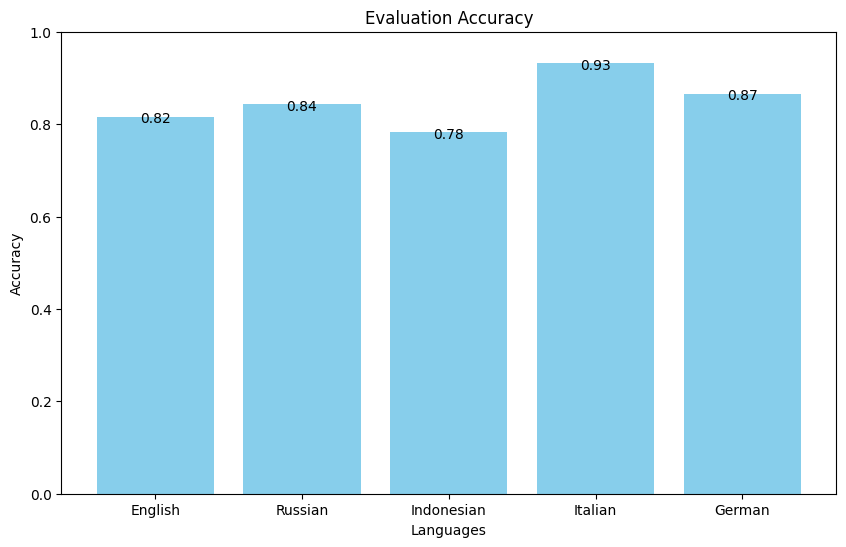

In [ ]:
import matplotlib.pyplot as plt

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(languages, accuracies, color="skyblue")  # Assign the result to 'bars'

# Add precision to bar labels
for bar, accuracy in zip(bars, accuracies):
  plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.02,
          f"{accuracy:.2f}", ha='center', va='bottom', fontsize=10)

# Add chart labels and title
plt.xlabel("Languages")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy")
plt.ylim(0, 1.0)
plt.show()